# Importing Required libraries

In [1]:
%run ./EODHD_Functions.ipynb
import requests
import pandas as pd
import datetime as dt
import numpy as np
import os as os
from textblob import TextBlob
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import matplotlib.pyplot as mdates
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import numpy as np

# Functions used in this file

In [2]:
def Calculate_volatility(df, days=30, price_col='adjusted_close'):
    """
    Calculate the N-day annualized volatility of a stock from a DataFrame of prices.
    Assumes daily frequency.

    Parameters:
    df : DataFrame
        DataFrame containing price data.
    days : int
        Number of days to use for volatility calculation.
    price_col : str
        Column name for price data.

    Returns:
    volatility : float
        Annualized volatility.
    """
    df = df.copy()
    df['log_return'] = np.log(df[price_col] / df[price_col].shift(1))
    last_n = df['log_return'].dropna()[-days:]
    volatility = last_n.std() * np.sqrt(252)
    return volatility

# Creating blackscholes option pricing model

In [3]:

def black_scholes(S, K, T, r, sigma):
    """
    Calculate Black-Scholes option price for European call and put.

    Parameters:
    S : float
        Current stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Risk-free interest rate (annual)
    sigma : float
        Volatility of the underlying asset (annual)

    Returns:
    call_price : float
        Price of the European call option
    put_price : float
        Price of the European put option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return call_price, put_price

In [ ]:
'''# Using black-scholes model to calculate option price

Function = EODHD_Functions()
end_date = dt.datetime.now()
days = 600
start_date = end_date - dt.timedelta(days=days)
s = Function.Fetch_historical_price("CA.PA", start_date,end_date,"d").iloc[-1]
T = 30/365
k = 12
r = 1.05
sigma = Calculate_volatility(Function.Fetch_historical_price("CA.PA", start_date,end_date,"d"),days)

CA_option_price = black_scholes(s['adjusted_close'], k, T, r/100, sigma)

print(f"Call Option Price: {CA_option_price[0]:.2f}, Put Option Price: {CA_option_price[1]:.2f}")'''

Call Option Price: 0.24, Put Option Price: 0.39


# Simulating jump diffusion stock price

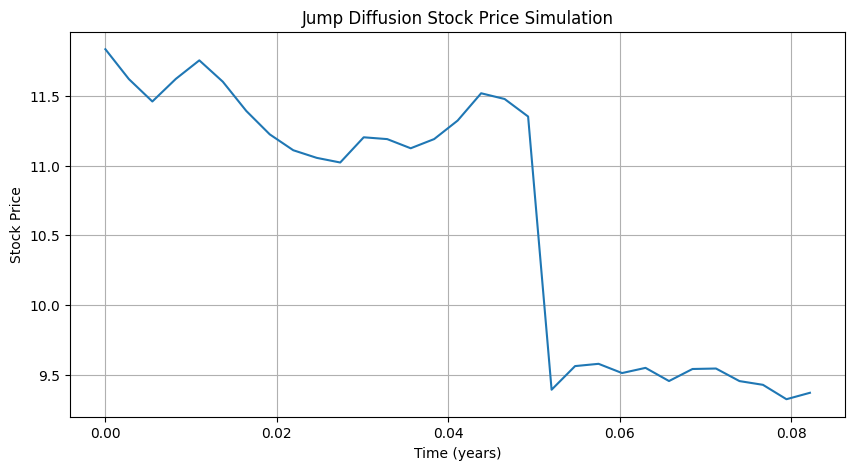

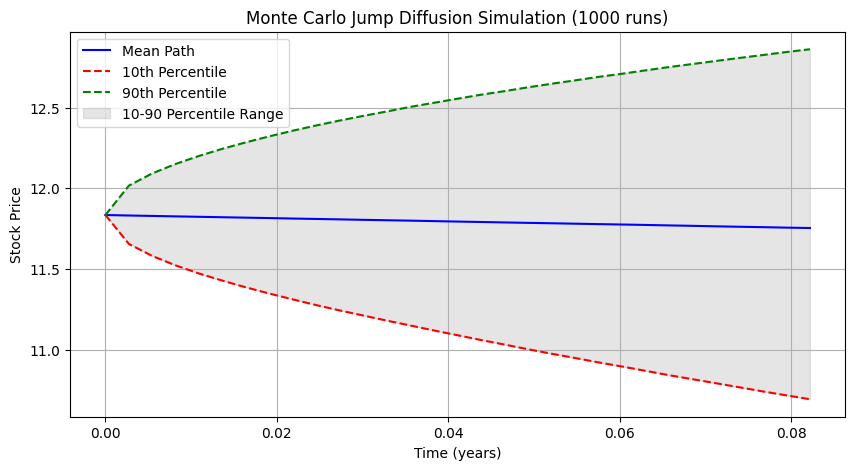

Final Mean Value: 11.75
Final 10th Percentile: 10.70
Final 90th Percentile: 12.86


In [ ]:
def simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N):
    dt = T / N
    t = np.linspace(0, T, N+1)
    S = np.zeros(N+1)
    S[0] = S0
    for i in range(1, N+1):
        # Poisson jump
        Nj = np.random.poisson(lamb * dt)
        if Nj > 0:
            jumps = np.sum(np.random.normal(mu_j, sigma_j, Nj))
        else:
            jumps = 0
        dW = np.random.normal(0, np.sqrt(dt))
        S[i] = S[i-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * dW + jumps)
    return t, S


In [ ]:
'''# Simulating jump diffusion model for a stock
# Parameters
S0 = s['adjusted_close']  # initial stock price as a float
mu = 0.05      # expected return
sigma = sigma   # volatility
lamb = 0.75   # average number of jumps per year
mu_j = -0.2   # mean of jump size (in log)
sigma_j = 0.1 # std dev of jump size (in log)
T = T         # time horizon (years)
N = 30       # number of steps (daily)

t, S = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)

plt.figure(figsize=(10,5))
plt.plot(t, S)
plt.title('Jump Diffusion Stock Price Simulation')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()
# Monte Carlo simulation for jump diffusion model
num_simulations = 1000000
all_paths = np.zeros((num_simulations, N+1))

for i in range(num_simulations):
    _, S_path = simulate_jump_diffusion(S0, mu, sigma, lamb, mu_j, sigma_j, T, N)
    all_paths[i, :] = S_path

# Calculate statistics
mean_path = np.mean(all_paths, axis=0)
p10_path = np.percentile(all_paths, 10, axis=0)
p90_path = np.percentile(all_paths, 90, axis=0)

plt.figure(figsize=(10,5))
plt.plot(t, mean_path, label='Mean Path', color='blue')
plt.plot(t, p10_path, label='10th Percentile', color='red', linestyle='--')
plt.plot(t, p90_path, label='90th Percentile', color='green', linestyle='--')
plt.fill_between(t, p10_path, p90_path, color='gray', alpha=0.2, label='10-90 Percentile Range')
plt.title('Monte Carlo Jump Diffusion Simulation (1000 runs)')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Print the final values at the end of the simulation
print(f"Final Mean Value: {mean_path[-1]:.2f}")
print(f"Final 10th Percentile: {p10_path[-1]:.2f}")
print(f"Final 90th Percentile: {p90_path[-1]:.2f}")'''